In [1]:
import os
import io
import warnings

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

**Global inputs**

In [3]:
EMBED_DIMS = 100
MAX_LENGTH = 120
TRUNC_TYPE = 'post'

**Example: IMDB movie review dataset** ([official webpage](http://ai.stanford.edu/~amaas/data/sentiment/)) 

In [4]:
# get the dataset
imdb = tfds.load('imdb_reviews', as_supervised=True, shuffle_files=False)

# split into training and testing
ds_train, ds_test = imdb['train'], imdb['test']

# extract the data
def extract(dataset):
    all_x, all_y = [], []
    for x, y in dataset:
        all_x.append(str(x.numpy()))
        all_y.append(y.numpy())
    return np.array(all_x), np.array(all_y)

# training dataset
x_train, y_train = extract(ds_train)
# testing dataset
x_test, y_test = extract(ds_test)

**Tokenize and pad**

In [5]:
# initiate a tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')

# update the vocabulary on training texts
tokenizer.fit_on_texts(x_train)

# vocabulary size
vocab_size = len(tokenizer.word_index)
print('# words in the vocabulary:', vocab_size)

# words in the vocabulary: 86539


In [6]:
# get sequences
sequences = tokenizer.texts_to_sequences(x_train)

# padding
padded_x_train = pad_sequences(
    sequences, padding='post', maxlen=MAX_LENGTH, truncating=TRUNC_TYPE
    )

print('padded shape:', padded_x_train.shape)

padded shape: (25000, 120)


In [7]:
# pad testing sequence
test_sequences = tokenizer.texts_to_sequences(x_test)
padded_x_test = pad_sequences(
    test_sequences, padding='post', maxlen=MAX_LENGTH, truncating=TRUNC_TYPE
    )

## GloVe
- Pre-trained embeddings. [See more](https://nlp.stanford.edu/projects/glove/).

**Download and prepare**

In [8]:
DATA_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt'
PATH_OUT = '../.tmp/glove.6B.100d.txt'
SAVE_MAT = '../.tmp/glove_embedding.npy'

# download the dataset
if not os.path.exists(PATH_OUT):
    os.system(f"""wget --no-check-certificate {DATA_URL} -O {PATH_OUT}""")

if os.path.exists(SAVE_MAT):
    embeddings_matrix = np.load(SAVE_MAT)
else:
    embeddings_index = {}
    with open(PATH_OUT, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embeddings_matrix = np.zeros((vocab_size+1, EMBED_DIMS))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector

    np.save(SAVE_MAT, embeddings_matrix)

**Model**
- Build a neural network model to learn the embeddings.

**Note**:
- We will use pre-trained `Embedding` layer.

In [9]:
# input layer
input_tensor = Input(shape=MAX_LENGTH)

# pre-trained embedding layer
x = Embedding(
    input_dim=vocab_size+1, 
    output_dim=EMBED_DIMS,
    input_length=MAX_LENGTH,
    weights=[embeddings_matrix], 
    trainable=False
)(input_tensor)

# hidden layers
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(pool_size=4)(x)
x = LSTM(64)(x)

# output layer with 'sigmoid' activation function
output_tensor = Dense(1, activation='sigmoid')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile with 'sparse_categorical_crossentropy' loss
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['acc']
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 120, 100)          8654000   
_________________________________________________________________
dropout (Dropout)            (None, 120, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65    

**Callbacks**

In [10]:
# reduce learning rate
reduce_rl = ReduceLROnPlateau(
    monitor='val_acc', mode='max', factor=0.1, patience=3, verbose=2
)

# stop training
early_stopping = EarlyStopping(
    monitor='val_acc',  mode='max', min_delta=0, patience=10, verbose=2, restore_best_weights=True
)

**Train**

In [11]:
# train the model
hist = model.fit(
    padded_x_train, y_train,
    batch_size=250,
    validation_data=(padded_x_test, y_test),
    epochs=50,
    verbose=1,
    callbacks=[reduce_rl, early_stopping]
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 5s 197us/sample - loss: 0.6113 - acc: 0.6606 - val_loss: 0.5919 - val_acc: 0.6946
Epoch 2/50
25000/25000 [==============================] - 2s 80us/sample - loss: 0.5399 - acc: 0.7320 - val_loss: 0.5141 - val_acc: 0.7427
Epoch 3/50
25000/25000 [==============================] - 2s 80us/sample - loss: 0.4896 - acc: 0.7648 - val_loss: 0.4698 - val_acc: 0.7750
Epoch 4/50
25000/25000 [==============================] - 2s 81us/sample - loss: 0.4641 - acc: 0.7802 - val_loss: 0.4561 - val_acc: 0.7837
Epoch 5/50
25000/25000 [==============================] - 2s 81us/sample - loss: 0.4255 - acc: 0.8042 - val_loss: 0.4199 - val_acc: 0.8081
Epoch 6/50
25000/25000 [==============================] - 2s 82us/sample - loss: 0.4168 - acc: 0.8077 - val_loss: 0.4396 - val_acc: 0.7890
Epoch 7/50
25000/25000 [==============================] - 2s 86us/sample - loss: 0.3963 - acc: 0.8189 - val_loss: 0

## **Show training graphs**

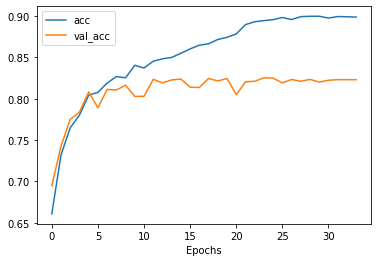

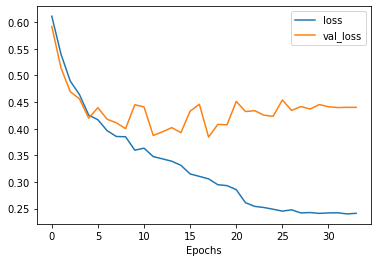

In [12]:
def plot_graphs(history, metrics):
    plt.figure()
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
  
plot_graphs(hist, ["acc", "val_acc"])
plot_graphs(hist, ["loss", "val_loss"])